# CIFAR10 Classifier. Model


This is the second part of the tutorial on how to train a classifier on CIFAR10 dataset. In this part we will create a Convolution Neural Network and modify some of modern architectures.

- [Create network blocks](#Create-network-blocks)
- [Load state-of-the-art architectures](#Load-state-of-the-art-architectures)
- [From CPU to GPU](#From-CPU-to-GPU)


References:
- [API](http://pytorch.org/docs/master/index.html)
- [pytorch-examples](https://github.com/pytorch/examples/tree/master/imagenet)
- [pytorch-tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py)


In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import torch
import torchvision

In [3]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
sys.path.append("common")

## Create network blocks

PyTorch provides `nn` module where implemented common bricks to construct neural networks: `Conv2d`, `MaxPool2d`, `BatchNorm2d`, `Linear`, ...


There are several ways to create a model:
- Extend `nn.Module` 
- Use `nn.Sequential`


Let's create a model composed of blocks `Conv2d+BatchNorm+ReLU` that forms inception blocks that are linearly assembled.

Reference to [Inception-ResNet article](https://arxiv.org/pdf/1602.07261.pdf) and [tf-slim implementation](https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v4.py)

In [5]:
from torch.autograd import Variable
from torch.nn import Module, Sequential
from torch.nn import Conv2d, BatchNorm2d, ReLU, Linear

In [6]:
class ConvBNR(Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvBNR, self).__init__()
        self.conv = Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = BatchNorm2d(out_channels)
        self.relu = ReLU(inplace=True)
    
    def forward(self, x):        
        return self.relu(self.bn(self.conv(x)))

In [7]:
from common.nn_utils import make_dot

Let's visualize conv+BN+Relu module

ConvBNR (
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
)


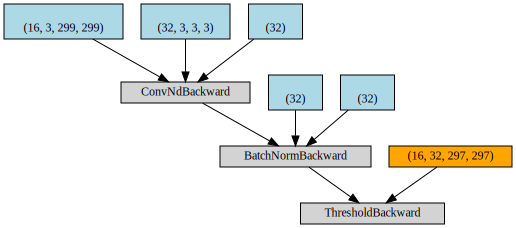

In [8]:
convbnr = ConvBNR(3, 32, kernel_size=3)
print(convbnr)
x = Variable(torch.Tensor(16, 3, 299, 299), requires_grad=True)
y = convbnr(x)
make_dot(y)  # This code is taken from https://github.com/szagoruyko/functional-zoo/blob/master/visualize.py

In [9]:
from torch.nn import AvgPool2d

In [10]:
class InceptionA(Module):
    
    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        
        self.branch_0 = ConvBNR(in_channels, 96, kernel_size=1, stride=1, padding=0)
        
        self.branch_1 = Sequential(
            ConvBNR(in_channels, 64, kernel_size=1, stride=1, padding=0),
            ConvBNR(64, 96, kernel_size=3, stride=1, padding=1)  
        )
        
        self.branch_2 = Sequential(
            ConvBNR(in_channels, 64, kernel_size=1, stride=1, padding=0),
            ConvBNR(64, 96, kernel_size=3, stride=1, padding=1),
            ConvBNR(96, 96, kernel_size=3, stride=1, padding=1)             
        )
        
        self.branch_3 = Sequential(
            AvgPool2d(3, stride=1, padding=1, count_include_pad=True),
            ConvBNR(in_channels, 96, kernel_size=1, stride=1, padding=0)
        )
        
    def forward(self, x):
        b0 = self.branch_0(x)
        b1 = self.branch_1(x)
        b2 = self.branch_2(x)
        b3 = self.branch_3(x)
        return torch.cat([b0, b1, b2, b3], dim=1)
    

What is `count_include_pad` ? According to the documention :
> count_include_pad: when True, will include the zero-padding in the averaging calculation


In [11]:
x = np.arange(9).reshape((3, 3)).astype(np.float32)
x = x[None, None, :, :]
x = Variable(torch.from_numpy(x))
pooling1 = AvgPool2d(2, stride=1, padding=1, count_include_pad=True)
pooling2 = AvgPool2d(2, stride=1, padding=1, count_include_pad=False)

In [12]:
x, pooling1(x), pooling2(x) 

(Variable containing:
 (0 ,0 ,.,.) = 
   0  1  2
   3  4  5
   6  7  8
 [torch.FloatTensor of size 1x1x3x3], Variable containing:
 (0 ,0 ,.,.) = 
   0.0000  0.2500  0.7500  0.5000
   0.7500  2.0000  3.0000  1.7500
   2.2500  5.0000  6.0000  3.2500
   1.5000  3.2500  3.7500  2.0000
 [torch.FloatTensor of size 1x1x4x4], Variable containing:
 (0 ,0 ,.,.) = 
   0.0000  0.5000  1.5000  2.0000
   1.5000  2.0000  3.0000  3.5000
   4.5000  5.0000  6.0000  6.5000
   6.0000  6.5000  7.5000  8.0000
 [torch.FloatTensor of size 1x1x4x4])

Now let's visualize Inception-A module

InceptionA (
  (branch_0): ConvBNR (
    (conv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
  )
  (branch_1): Sequential (
    (0): ConvBNR (
      (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
    )
    (1): ConvBNR (
      (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
    )
  )
  (branch_2): Sequential (
    (0): ConvBNR (
      (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
    )
    (1): ConvBNR (
      (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
      (relu): R

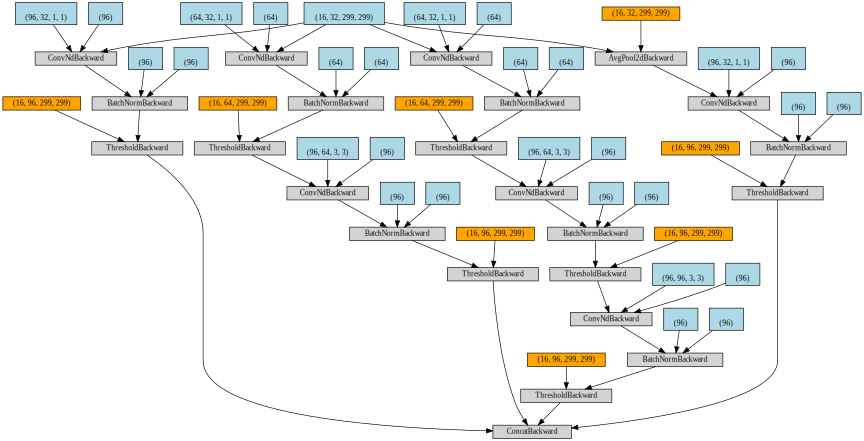

In [13]:
inception_a = InceptionA(32)
print(inception_a)
x = Variable(torch.Tensor(16, 32, 299, 299), requires_grad=True)
y = inception_a(x)
make_dot(y)

In such way one can implement a model architecture. 

Let's now estimate the number of trainable parameters:

In [14]:
from common.nn_utils import print_trainable_parameters

In [15]:
print_trainable_parameters(convbnr)

conv.weight torch.Size([32, 3, 3, 3])
conv.bias torch.Size([32])
bn.weight torch.Size([32])
bn.bias torch.Size([32])

Total number of trainable parameters:  960


In [16]:
print_trainable_parameters(inception_a)

branch_0.conv.weight torch.Size([96, 32, 1, 1])
branch_0.conv.bias torch.Size([96])
branch_0.bn.weight torch.Size([96])
branch_0.bn.bias torch.Size([96])
branch_1.0.conv.weight torch.Size([64, 32, 1, 1])
branch_1.0.conv.bias torch.Size([64])
branch_1.0.bn.weight torch.Size([64])
branch_1.0.bn.bias torch.Size([64])
branch_1.1.conv.weight torch.Size([96, 64, 3, 3])
branch_1.1.conv.bias torch.Size([96])
branch_1.1.bn.weight torch.Size([96])
branch_1.1.bn.bias torch.Size([96])
branch_2.0.conv.weight torch.Size([64, 32, 1, 1])
branch_2.0.conv.bias torch.Size([64])
branch_2.0.bn.weight torch.Size([64])
branch_2.0.bn.bias torch.Size([64])
branch_2.1.conv.weight torch.Size([96, 64, 3, 3])
branch_2.1.conv.bias torch.Size([96])
branch_2.1.bn.weight torch.Size([96])
branch_2.1.bn.bias torch.Size([96])
branch_2.2.conv.weight torch.Size([96, 96, 3, 3])
branch_2.2.conv.bias torch.Size([96])
branch_2.2.bn.weight torch.Size([96])
branch_2.2.bn.bias torch.Size([96])
branch_3.1.conv.weight torch.Size([9

## Load state-of-the-art architectures 

Let's now load an existing architecture.

Here is some sources of implemented models (with pretrained weights)
- [Torchvision](http://pytorch.org/docs/master/torchvision/models.html):     
    - AlexNet
    - VGG
    - ResNet
    - SqueezeNet
    - DenseNet
    - Inception v3
- [Cadene:](https://github.com/Cadene/pretrained-models.pytorch)
    - InceptionResNetV2
    - InceptionV4
    - ResNeXt
    - ...
    
Let's load DenseNet161 ([paper](https://arxiv.org/pdf/1608.06993.pdf))

In [17]:
from torchvision.models import densenet161

In [18]:
densenet = densenet161()
print(densenet)

DenseNet (
  (features): Sequential (
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU (inplace)
    (pool0): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock (
      (denselayer1): _DenseLayer (
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU (inplace)
        (conv.1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU (inplace)
        (conv.2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer (
        (norm.1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU (inplace)
        (conv.1): Conv2d(144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [19]:
print_trainable_parameters(densenet)

features.conv0.weight torch.Size([96, 3, 7, 7])
features.norm0.weight torch.Size([96])
features.norm0.bias torch.Size([96])
features.denseblock1.denselayer1.norm.1.weight torch.Size([96])
features.denseblock1.denselayer1.norm.1.bias torch.Size([96])
features.denseblock1.denselayer1.conv.1.weight torch.Size([192, 96, 1, 1])
features.denseblock1.denselayer1.norm.2.weight torch.Size([192])
features.denseblock1.denselayer1.norm.2.bias torch.Size([192])
features.denseblock1.denselayer1.conv.2.weight torch.Size([48, 192, 3, 3])
features.denseblock1.denselayer2.norm.1.weight torch.Size([144])
features.denseblock1.denselayer2.norm.1.bias torch.Size([144])
features.denseblock1.denselayer2.conv.1.weight torch.Size([192, 144, 1, 1])
features.denseblock1.denselayer2.norm.2.weight torch.Size([192])
features.denseblock1.denselayer2.norm.2.bias torch.Size([192])
features.denseblock1.denselayer2.conv.2.weight torch.Size([48, 192, 3, 3])
features.denseblock1.denselayer3.norm.1.weight torch.Size([192])


Note that the last layer has no softmax activation applied to provide the probabilities (logits).

Let's modify the top layer of DenseNet161 model for CIFAR10 classification task. The last layer is fully-connected, called here 'classifier', and transforms 2208 channels input into 1000 channels output. We change it by a layer: `2208 -> 10`: 

In [20]:
densenet.classifier, type(densenet.classifier) 

(Linear (2208 -> 1000), torch.nn.modules.linear.Linear)

In [21]:
densenet.classifier = Linear(2208, 10)

In [22]:
print_trainable_parameters(densenet)

features.conv0.weight torch.Size([96, 3, 7, 7])
features.norm0.weight torch.Size([96])
features.norm0.bias torch.Size([96])
features.denseblock1.denselayer1.norm.1.weight torch.Size([96])
features.denseblock1.denselayer1.norm.1.bias torch.Size([96])
features.denseblock1.denselayer1.conv.1.weight torch.Size([192, 96, 1, 1])
features.denseblock1.denselayer1.norm.2.weight torch.Size([192])
features.denseblock1.denselayer1.norm.2.bias torch.Size([192])
features.denseblock1.denselayer1.conv.2.weight torch.Size([48, 192, 3, 3])
features.denseblock1.denselayer2.norm.1.weight torch.Size([144])
features.denseblock1.denselayer2.norm.1.bias torch.Size([144])
features.denseblock1.denselayer2.conv.1.weight torch.Size([192, 144, 1, 1])
features.denseblock1.denselayer2.norm.2.weight torch.Size([192])
features.denseblock1.denselayer2.norm.2.bias torch.Size([192])
features.denseblock1.denselayer2.conv.2.weight torch.Size([48, 192, 3, 3])
features.denseblock1.denselayer3.norm.1.weight torch.Size([192])


## From CPU to GPU

It is simple as for tensors, simply call `.cuda()` on the model
> Remember that you will have to send the inputs and targets at every step to the GPU too:

> `inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())`
    
References:
- [cifar10-tutorial](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu)

In [23]:
!nvidia-smi --format=csv --query-gpu=memory.used

memory.used [MiB]
0 MiB


In [24]:
densenet = densenet.cuda()

In [25]:
!nvidia-smi --format=csv --query-gpu=memory.used

memory.used [MiB]
457 MiB
